# Perusahaan asuransi "Sure Tomorrow"

Perusahaan asuransi bernama "Sure Tomorrow" ingin menyelesaikan beberapa masalah dengan bantuan *machine learning*. Anda pun diminta untuk mengevaluasi kemungkinan tersebut.

- Tugas 1: Temukan klien yang mirip dengan kriteria klien tertentu. Tugas ini akan memudahkan perusahaan untuk melakukan pemasaran.
- Tugas 2: Prediksi apakah klien baru kemungkinan akan mengambil klaim asuransi. Apakah prediksi model lebih baik daripada prediksi model *dummy*?
- Tugas 3: Prediksi besaran klaim asuransi yang mungkin diterima klien baru menggunakan model regresi linear.
- Tugas 4: Lindungi data pribadi klien tanpa merusak model dari tugas sebelumnya. Sangatlah penting untuk mengembangkan algoritme transformasi data yang dapat mencegah penyalahgunaan informasi pribadi klien jika data tersebut jatuh ke tangan yang salah. Hal ini disebut penyembunyian data atau pengaburan data. Namun, prosedur perlindungan datanya pun perlu diperhatikan agar kualitas *model machine* learning tidak menurun. Di sini, Anda tidak perlu memilih model yang terbaik, cukup buktikan bahwa algoritme Anda bekerja secara akurat.

# Pra-pemrosesan & Eksplorasi Data

## Inisialisasi

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import sklearn.metrics
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from IPython.display import display

## Muat Data

Muat data dan lakukan pemeriksaan untuk memastikan data bebas dari permasalahan.

In [2]:
df = pd.read_csv('/datasets/insurance_us.csv')

Kami mengganti nama kolom untuk membuat kode terlihat lebih konsisten dengan gayanya.

In [3]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [4]:
df.head()

,gender,age,income,family_members,insurance_benefits
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [6]:
# mengubah tipe data di kolom age menjadi tipe integer
df['age'] = df['age'].astype(int)

In [7]:
# Mengecek tipe kolom
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [8]:
#Mengecek apakah ada data duplikat
df.duplicated().sum()

153

In [9]:
#Membersihkan data duplicat
df = df.drop_duplicates()

In [10]:
# Sekarang, amati statistika deskriptif dari data kita. 
# Apakah semuanya sudah benar?

## EDA

Mari kita periksa dengan cepat, apakah ada kelompok pelanggan tertentu dengan melihat plot pasangan?

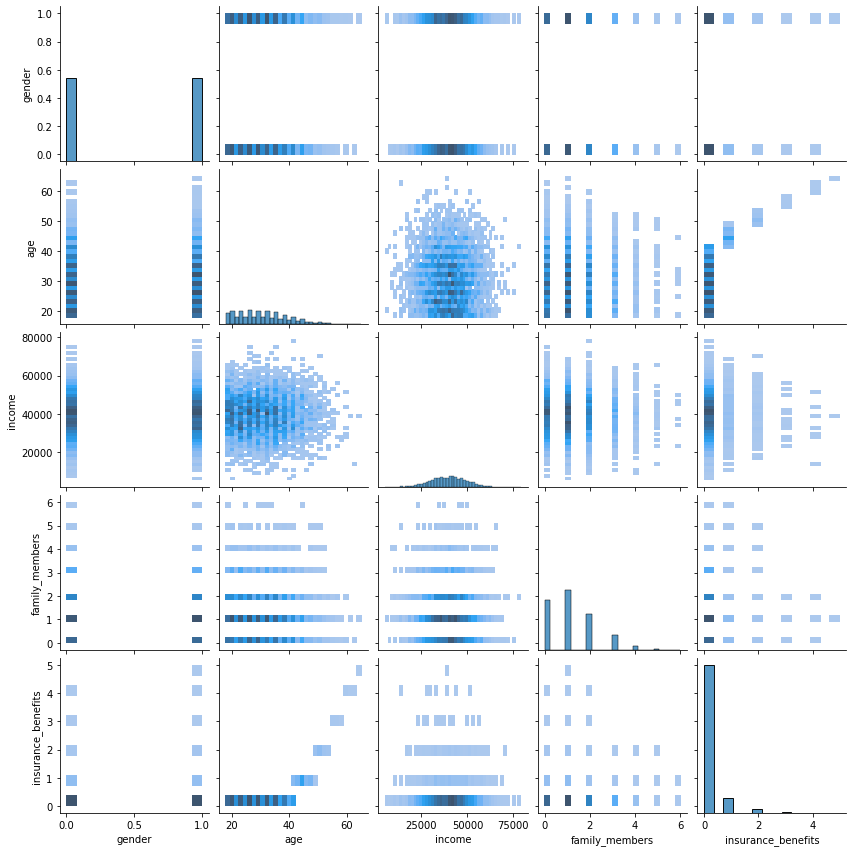

In [11]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Baiklah, sepertinya agak sulit untuk melihat kelompok (klaster) yang jelas mengingat sulitnya menggabungkan beberapa variabel secara bersamaan (untuk menganalisis distribusi multivariat). Namun, itulah gunanya LA dan ML di sini.

# Tugas 1. Klien yang Mirip

Dalam bahasa pemrograman ML, penting untuk mengembangkan prosedur yang bisa menentukan *k-nearest neighbors* (objek) pada objek tertentu berdasarkan jarak antar objek.

Anda mungkin ingin mengulas kembali pelajaran berikut (bab -> pelajaran)
- Jarak Antar Vektor -> Jarak Euklides
- Jarak Antar Vektor -> Jarak Manhattan

Untuk menyelesaikan tugas ini, kita bisa mencoba beberapa metrik jarak.

Buatlah sebuah fungsi yang menampilkan *k-nearest neighbors* terdekat untuk objek ke-n berdasarkan metrik jarak tertentu.  Besarnya klaim asuransi yang diterima tidak perlu diperhitungkan dalam tugas ini.

Anda bisa menggunakan implementasi algoritme kNN yang sudah tersedia di Scikit-learn  (periksa [tautan](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors) ini) atau menggunakan punya Anda sendiri.

Uji algoritme tersebut untuk empat kombinasi dari dua kasus
- Penskalaan
  - data tidak diskalakan
  - data diskalakan dengan [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) 
- Metrik Jarak
  - Euklides
  - Manhattan

Jawablah pertanyaan-pertanyaan berikut:
- Apakah data yang tidak berskala memengaruhi algoritme kNN? Jika berpengaruh, lalu bagaimanakah bentuknya?
- Seberapa mirip hasil yang Anda dapatkan dari metrik Euklides dengan saat Anda menggunakan metrik jarak Manhattan (abaikan ada atau tidaknya skala)?

In [12]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [13]:
def get_knn(df, n, k, metric):
    
    """
    Menampilkan k nearest neighbors

    :param df: DataFrame Pandas digunakan untuk menemukan objek-objek yang mirip di dalamnya
    :param n: nomor objek yang dicari k nearest neighbors
    :param k: jumlah k nearest neighbors yang ditampilkan
    :param metric: nama metrik jarak
    """

    nbrs = NearestNeighbors(n_neighbors=k, algorithm='brute', metric = metric).fit(df[feature_names]) 
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    list_index = df.iloc[nbrs_indices[0]].index
    
    df_res = pd.concat([df.iloc[nbrs_indices[0]].reset_index(drop=True), pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance']).reset_index(drop=True)
        ], axis=1).set_index(list_index)
    
    return df_res

In [14]:
#List orang yang dekat dengan orang di indeks 100
get_knn(df, n=100, k=5, metric='euclidean')

,gender,age,income,family_members,insurance_benefits,distance
100,0,19,37300.0,1,0,0.000000
1831,0,20,37300.0,2,0,1.414214
4278,1,19,37300.0,2,0,1.414214
2624,1,19,37300.0,0,0,1.414214
1086,0,22,37300.0,3,0,3.605551


Mengatur skala data.

In [15]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [16]:
df_scaled.head()

,gender,age,income,family_members,insurance_benefits
0,1.0,0.630769,0.627848,0.166667,0
1,0.0,0.707692,0.481013,0.166667,1
2,0.0,0.446154,0.265823,0.000000,0
3,0.0,0.323077,0.527848,0.333333,0
4,1.0,0.430769,0.330380,0.000000,0


Sekarang, mari kita dapatkan catatan yang mirip untuk setiap kombinasi yang ada

In [17]:
#List orang yang dekat dengan orang di indeks 100 setelah dilakukan scaling
get_knn(df_scaled, n=100, k=5, metric='euclidean')

,gender,age,income,family_members,insurance_benefits,distance
100,0.0,0.292308,0.472152,0.166667,0,0.000000
243,0.0,0.292308,0.467089,0.166667,0,0.005063
4915,0.0,0.292308,0.477215,0.166667,0,0.005063
1323,0.0,0.292308,0.456962,0.166667,0,0.015190
811,0.0,0.307692,0.470886,0.166667,0,0.015437


In [18]:
get_knn(df_scaled, n=100, k=5, metric='manhattan')

,gender,age,income,family_members,insurance_benefits,distance
100,0.0,0.292308,0.472152,0.166667,0,0.000000
4915,0.0,0.292308,0.477215,0.166667,0,0.005063
243,0.0,0.292308,0.467089,0.166667,0,0.005063
1323,0.0,0.292308,0.456962,0.166667,0,0.015190
811,0.0,0.307692,0.470886,0.166667,0,0.016650


Jawab pertanyaannya

**Apakah data yang tidak berskala memengaruhi algoritme kNN? Jika berpengaruh, lalu bagaimanakah bentuknya?** 

Data yang tidak berskala memengaruhi algoritma kNN dimana data yang ditemukan adalah data yang memiliki nilai income mirip, hal karena nilai yang besar akan selalu dominan. Jika dihitung dengan pythagoras nilainya akan mendekati nilai dominan tersebut.

**Seberapa mirip hasil yang Anda dapatkan dari metrik Euklides dengan saat Anda menggunakan metrik jarak Manhattan (abaikan ada atau tidaknya skala)?** 

Metrik Euklides dengan metrik Manhattan menghasilkan data yang sama.

# Tugas 2. Apakah klien kemungkinan menerima klaim asuransi?

Dalam konteks *machine learning*, tugas ini sama seperti tugas klasifikasi biner.

Dengan target insurance_benefits yang lebih dari nol, coba evaluasi apakah model klasifikasi kNN merupakan pendekatan yang lebih baik daripada model *dummy*.

Instruksi:
- Buat pengklasifikasi berbasis KNN dan ukur kualitasnya dengan metrik F1 untuk k=1..10 bagi data asli dan data yang diskalakan. Akan menarik untuk melihat bagaimana k dapat memengaruhi metrik evaluasi, dan apakah penskalaan data membuat hasilnya berbeda. Gunakan implementasi algoritme klasifikasi kNN yang tersedia di Scikit-learn (periksa [tautan ini](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) atau gunakan milik Anda sendiri.
- Buat model *dummy* yang acak untuk kasus ini. Model tersebut harusnya menampilkan "1" dengan beberapa probabilitas. Mari kita uji model dengan empat nilai probabilitas: 0, probabilitas membayar benefit asuransi apa pun; 0,5; 1.

Probabilitas membayar klaim asuransi dapat didefinisikan sebagai

$$
P\{\text{klaim asuransi yang diterima}\}=\frac{\text{jumlah klien yang menerima klaim asuransi}}{\text{jumlah klien secara keseluruhan}}.
$$

Pisahkan keseluruhan data menjadi 70:30 untuk proporsi *training* dan *test set*.

In [19]:
df['insurance_benefits'].value_counts()

0    4284
1     423
2     114
3      18
4       7
5       1
Name: insurance_benefits, dtype: int64

In [20]:
#Mmebuat kolom baru untuk mengubah jumlah klaim yang lebih dari satu menjadi 1 dan yang belum pernah klaim tetap 0
df['insurance_benefits_received'] = (df['insurance_benefits'] > 0).astype('int')

In [21]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits,insurance_benefits_received
2362,1,32,30800.0,0,0,0
2333,0,47,43900.0,0,1,1
216,0,32,42200.0,1,0,0
4496,0,39,46700.0,2,0,0
2584,1,20,33600.0,0,0,0
4714,0,24,33700.0,3,0,0
1031,1,22,50100.0,1,0,0
766,1,29,51500.0,5,0,0
3978,0,24,36300.0,0,0,0
4252,1,45,50800.0,1,1,1


In [22]:
# periksa ketidakseimbangan kelas dengan value_counts()
df['insurance_benefits_received'].value_counts()

0    4284
1     563
Name: insurance_benefits_received, dtype: int64

In [23]:
#Membuat model dummy yang ouputnya prediksi acak 
#untuk membuktikan apakah model yang dibuat lebih baik dari model sesungguhnya
def dummy_model(probability, size=len(df)):
    rng = np.random.default_rng(seed=12)
    prediction = rng.binomial(n=1, p=probability, size=size)
    return prediction

In [24]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred, average='micro')
    print(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriks Kesalahan')
    print(cm)

In [25]:
#Membuat target
y_true = df['insurance_benefits_received']

In [26]:
#Prediksi model dengan dummy dengan proporsi 90:10
y_pred_dummy = dummy_model(probability=0.1, size=len(df))
eval_classifier(y_true, y_pred_dummy)

F1: 0.81
Matriks Kesalahan
[[0.79471838 0.0891273 ]
 [0.10501341 0.01114091]]


In [27]:
#Train test split
X = df[feature_names]
y = df['insurance_benefits_received']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [28]:
#Scaling data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=feature_names)
X_train.head()

,gender,age,income,family_members
0,-0.999742,-1.186407,-0.224105,1.622794
1,-0.999742,-0.949242,0.170696,-1.095339
2,1.000258,-1.304990,1.112145,1.622794
3,1.000258,1.896740,-2.147496,-0.189295
4,1.000258,-0.119164,0.089711,-1.095339


In [29]:
X_test = pd.DataFrame(scaler.transform(X_test), columns=feature_names)
X_test.head()

,gender,age,income,family_members
0,1.000258,-0.237746,1.061529,-0.189295
1,-0.999742,-0.119164,-1.428755,-1.095339
2,-0.999742,1.066662,0.150450,1.622794
3,1.000258,0.118001,-0.821369,-1.095339
4,1.000258,1.659575,-0.426567,-1.095339


In [30]:
#Membuat jarak dengan kNN
# neighbor=3 karena hasilnya yang memiliki F1 tinggi daripada nilai lain
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [31]:
#Prediksi data training
y_pred_train = knn.predict(X_train)
eval_classifier(y_train, y_pred_train)

F1: 0.99
Matriks Kesalahan
[[8.85478463e-01 7.73794171e-04]
 [4.38483363e-03 1.09362909e-01]]


In [32]:
#Prediksi data testing
y_pred_test = knn.predict(X_test)
eval_classifier(y_test, y_pred_test)

F1: 0.99
Matriks Kesalahan
[[0.87216495 0.00206186]
 [0.01134021 0.11443299]]


# Tugas 3. Regresi (dengan Regresi Linear)

Dengan `insurance_benefit` sebagai target, evaluasi berapa RMSE untuk model Regresi Linear.

Buat implementasi LR Anda sendiri. Untuk itu, coba ingat-ingat kembali bagaimana solusi tugas regresi linear dirumuskan dalam bentuk LA. Periksa RMSE untuk data asli maupun data yang telah diskalakan. Bisakah Anda melihat perbedaan RMSE di antara kedua kasus ini?

Tunjukkan
- $X$ — matriks fitur, satu baris merepresentasikan satu kasus, tiap kolom adalah fitur, kolom pertama terdiri dari satuan
- $y$ — target (vektor)
- $\hat{y}$ — estimasi target (vektor)
- $w$ — bobot vektor

Matriks untuk regresi linear dapat dirumuskan sebagai

$$
y = Xw
$$

Tujuan pelatihan untuk menemukan $w$ yang akan meminimalkan jarak L2 (MSE) antara $Xw$ dan $y$:

$$
\min_w d_2(Xw, y) \quad \text{atau} \quad \min_w \text{MSE}(Xw, y)
$$

Sepertinya ada solusi analitis untuk masalah di atas:

$$
w = (X^T X)^{-1} X^T y
$$

Rumus di atas bisa digunakan untuk menemukan bobot $w$ dan yang terakhir dapat digunakan untuk menghitung nilai prediksi

$$
\hat{y} = X_{val}w
$$

Pisahkan keseluruhan data menjadi *training set* dan *validation set* dengan proporsi 70:30. Gunakan metrik RMSE untuk evaluasi model.

In [33]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # menambahkan satuan
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T @ X2) @ X2.T @ y

    def predict(self, X):
        
        # menambahkan satuan
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [34]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [35]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.77366729e-01  3.58042291e-02  1.95594888e-02  5.85336165e-07
 -1.21618420e-02]
RMSE: 0.36
R2: 0.66


# Tugas 4. Pengaburan Data

Cara terbaik untuk mengaburkan data adalah dengan mengalikan fitur-fitur numerik (ingat bahwa fitur-fitur tersebut bisa di lihat di matriks $X$) dengan matriks yang dapat dibalik (*invertible*) $P$. 

$$
X' = X \times P
$$

Coba lakukan itu dan periksa bagaimana nilai fitur akan terlihat setelah transformasi. Sifat *invertible* sangat penting pada kasus ini, jadi pastikan $P$ bahwa $P$ bersifat *invertible*.

Anda mungkin ingin meninjau kembali pelajaran 'Matriks dan Operasi Matriks -> Perkalian Matriks' untuk mengingat aturan perkalian matriks dan implementasinya dengan NumPy.

In [36]:
#Pilih data yang akan di masking
df_masking = df[feature_names]
df_masking.head()

,gender,age,income,family_members
0,1,41,49600.0,1
1,0,46,38000.0,1
2,0,29,21000.0,0
3,0,21,41700.0,2
4,1,28,26100.0,0


In [37]:
df_masking = df_masking.to_numpy()

Membuat matriks acak $P$.

In [38]:
rng = np.random.default_rng(seed=12)
P = rng.random(size=(df_masking.shape[1], df_masking.shape[1]))

Memeriksa apakah matriks $P$ *invertible*

In [39]:
P_det = np.linalg.det(P)
P_det


0.1909965984971535

In [40]:
df_masking = df_masking @ P
df_masking = pd.DataFrame(df_masking, columns=feature_names)
df_masking.head()

,gender,age,income,family_members
0,44471.648070,42573.929158,168.315288,26862.072783
1,34075.957957,32619.821437,138.684623,20581.461413
2,18832.643636,18027.425967,78.810602,11374.126698
3,37383.662260,35789.398671,132.800395,22582.462843
4,23403.722377,22404.607673,92.747341,14135.668335


In [41]:
pd.concat([df, df_masking], axis=1, keys=['ASLI', 'MASKED'])

ASLI                                                   \
     gender   age   income family_members insurance_benefits   
0       1.0  41.0  49600.0            1.0                0.0   
1       0.0  46.0  38000.0            1.0                1.0   
2       0.0  29.0  21000.0            0.0                0.0   
3       0.0  21.0  41700.0            2.0                0.0   
4       1.0  28.0  26100.0            0.0                0.0   
...     ...   ...      ...            ...                ...   
4995    0.0  28.0  35700.0            2.0                0.0   
4996    0.0  34.0  52400.0            1.0                0.0   
4997    0.0  20.0  33900.0            2.0                0.0   
4998    1.0  22.0  32700.0            3.0                0.0   
4999    1.0  28.0  40600.0            1.0                0.0   

                                        MASKED                            \
     insurance_benefits_received        gender           age      income   
0                            0.0  44471.648070  42573.929158  168.315288   
1                            1.0  34075.957957  32619.821437  138.684623   
2                            0.0  18832.643636  18027.425967   78.810602   
3                            0.0  37383.662260  35789.398671  132.800395   
4                            0.0  23403.722377  22404.607673   92.747341   
...                          ...           ...           ...         ...   
4995                         0.0           NaN           NaN         NaN   
4996                         0.0           NaN           NaN         NaN   
4997                         0.0           NaN           NaN         NaN   
4998                         0.0           NaN           NaN         NaN   
4999                         0.0           NaN           NaN         NaN   

                     
     family_members  
0      26862.072783  
1      20581.461413  
2      11374.126698  
3      22582.462843  
4      14135.668335  
...             ...  
4995            NaN  
4996            NaN  
4997            NaN  
4998            NaN  
4999            NaN  

[4996 rows x 10 columns]

In [42]:
#mengembalkikan data yang sudah dimaskinh
p_inv = np.linalg.inv(P)
df_balik = df_masking @ p_inv
df_balik.columns = feature_names
df_balik.head

<bound method NDFrame.head of             gender   age   income  family_members
0     1.000000e+00  41.0  49600.0    1.000000e+00
1     4.366389e-12  46.0  38000.0    1.000000e+00
2    -3.949705e-13  29.0  21000.0   -7.439907e-12
3     1.419964e-12  21.0  41700.0    2.000000e+00
4     1.000000e+00  28.0  26100.0   -5.816794e-12
...            ...   ...      ...             ...
4842  4.384041e-12  28.0  35700.0    2.000000e+00
4843  4.729353e-12  34.0  52400.0    1.000000e+00
4844  4.077441e-12  20.0  33900.0    2.000000e+00
4845  1.000000e+00  22.0  32700.0    3.000000e+00
4846  1.000000e+00  28.0  40600.0    1.000000e+00

[4847 rows x 4 columns]>

In [43]:
pd.concat([df, df_masking, df_balik], axis=1, keys=['ASLI', 'MASKED', 'RETURNED'])

ASLI                                                   \
     gender   age   income family_members insurance_benefits   
0       1.0  41.0  49600.0            1.0                0.0   
1       0.0  46.0  38000.0            1.0                1.0   
2       0.0  29.0  21000.0            0.0                0.0   
3       0.0  21.0  41700.0            2.0                0.0   
4       1.0  28.0  26100.0            0.0                0.0   
...     ...   ...      ...            ...                ...   
4995    0.0  28.0  35700.0            2.0                0.0   
4996    0.0  34.0  52400.0            1.0                0.0   
4997    0.0  20.0  33900.0            2.0                0.0   
4998    1.0  22.0  32700.0            3.0                0.0   
4999    1.0  28.0  40600.0            1.0                0.0   

                                        MASKED                            \
     insurance_benefits_received        gender           age      income   
0                            0.0  44471.648070  42573.929158  168.315288   
1                            1.0  34075.957957  32619.821437  138.684623   
2                            0.0  18832.643636  18027.425967   78.810602   
3                            0.0  37383.662260  35789.398671  132.800395   
4                            0.0  23403.722377  22404.607673   92.747341   
...                          ...           ...           ...         ...   
4995                         0.0           NaN           NaN         NaN   
4996                         0.0           NaN           NaN         NaN   
4997                         0.0           NaN           NaN         NaN   
4998                         0.0           NaN           NaN         NaN   
4999                         0.0           NaN           NaN         NaN   

                         RETURNED                                
     family_members        gender   age   income family_members  
0      26862.072783  1.000000e+00  41.0  49600.0   1.000000e+00  
1      20581.461413  4.366389e-12  46.0  38000.0   1.000000e+00  
2      11374.126698 -3.949705e-13  29.0  21000.0  -7.439907e-12  
3      22582.462843  1.419964e-12  21.0  41700.0   2.000000e+00  
4      14135.668335  1.000000e+00  28.0  26100.0  -5.816794e-12  
...             ...           ...   ...      ...            ...  
4995            NaN           NaN   NaN      NaN            NaN  
4996            NaN           NaN   NaN      NaN            NaN  
4997            NaN           NaN   NaN      NaN            NaN  
4998            NaN           NaN   NaN      NaN            NaN  
4999            NaN           NaN   NaN      NaN            NaN  

[4996 rows x 14 columns]

In [44]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(df_masking, y, test_size=0.2, random_state=10)


In [45]:
#Scaling data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = pd.DataFrame(scaler.transform(X_train), columns=feature_names)
X_train.head()

,gender,age,income,family_members
0,-0.224495,-0.224380,-0.434645,-0.224187
1,0.170352,0.170387,-0.042304,0.170406
2,1.111756,1.111964,0.865520,1.112086
3,-2.146872,-2.147026,-1.738015,-2.147170
4,0.089672,0.089703,0.050201,0.089604


In [46]:
X_test = pd.DataFrame(scaler.transform(X_test), columns=feature_names)
X_test.head()

,gender,age,income,family_members
0,1.061472,1.061532,0.999177,1.061494
1,-1.428837,-1.428885,-1.453239,-1.428907
2,0.150814,0.150694,0.384177,0.150780
3,-0.821337,-0.821328,-0.800525,-0.821440
4,-0.426019,-0.426171,-0.103732,-0.426356


In [47]:
#Bikin model dengan kNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

#Prediksi data training
y_pred_train = knn.predict(X_train)
eval_classifier(y_train, y_pred_train)

#Prediksi data testing
y_pred_test = knn.predict(X_test)
eval_classifier(y_test, y_pred_test)

F1: 0.97
Matriks Kesalahan
[[8.79030178e-01 7.22207893e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [9.54346144e-03 7.76373485e-02 1.03172556e-03 0.00000000e+00
  0.00000000e+00]
 [2.57931390e-04 3.86897085e-03 1.54758834e-02 2.57931390e-04
  0.00000000e+00]
 [0.00000000e+00 5.15862781e-04 1.80551973e-03 1.54758834e-03
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.54758834e-03 2.57931390e-04
  0.00000000e+00]]
F1: 0.95
Matriks Kesalahan
[[0.86907216 0.00515464 0.         0.         0.        ]
 [0.01340206 0.06494845 0.00515464 0.         0.        ]
 [0.00103093 0.02061856 0.01340206 0.00309278 0.        ]
 [0.         0.         0.00309278 0.         0.        ]
 [0.         0.         0.00103093 0.         0.        ]]


Bisakah Anda menebak usia klien atau pendapatannya setelah dilakukan transformasi?

Tidak

Bisakah Anda memulihkan data asli dari $X'$ jika $P$ sudah diketahui? Coba periksa hal tersebut melalui perhitungan dengan memindahkan $P$ dari sisi kanan rumus di atas ke sisi kiri. Aturan perkalian matriks sangat berguna di sini.

kita dapat memulihkan data asli $X$ dari $X'$ jika matriks transformasi $P$ diketahu, caranya adalah 

Tampilkan ketiga kasus untuk beberapa klien
- Data asli
- Data yang sudah ditransformasikan
- Data yang telah dipulihkan ke semula

In [48]:
pd.concat([df, df_masking, df_balik], axis=1, keys=['ASLI', 'MASKED', 'RETURNED'])

ASLI                                                   \
     gender   age   income family_members insurance_benefits   
0       1.0  41.0  49600.0            1.0                0.0   
1       0.0  46.0  38000.0            1.0                1.0   
2       0.0  29.0  21000.0            0.0                0.0   
3       0.0  21.0  41700.0            2.0                0.0   
4       1.0  28.0  26100.0            0.0                0.0   
...     ...   ...      ...            ...                ...   
4995    0.0  28.0  35700.0            2.0                0.0   
4996    0.0  34.0  52400.0            1.0                0.0   
4997    0.0  20.0  33900.0            2.0                0.0   
4998    1.0  22.0  32700.0            3.0                0.0   
4999    1.0  28.0  40600.0            1.0                0.0   

                                        MASKED                            \
     insurance_benefits_received        gender           age      income   
0                            0.0  44471.648070  42573.929158  168.315288   
1                            1.0  34075.957957  32619.821437  138.684623   
2                            0.0  18832.643636  18027.425967   78.810602   
3                            0.0  37383.662260  35789.398671  132.800395   
4                            0.0  23403.722377  22404.607673   92.747341   
...                          ...           ...           ...         ...   
4995                         0.0           NaN           NaN         NaN   
4996                         0.0           NaN           NaN         NaN   
4997                         0.0           NaN           NaN         NaN   
4998                         0.0           NaN           NaN         NaN   
4999                         0.0           NaN           NaN         NaN   

                         RETURNED                                
     family_members        gender   age   income family_members  
0      26862.072783  1.000000e+00  41.0  49600.0   1.000000e+00  
1      20581.461413  4.366389e-12  46.0  38000.0   1.000000e+00  
2      11374.126698 -3.949705e-13  29.0  21000.0  -7.439907e-12  
3      22582.462843  1.419964e-12  21.0  41700.0   2.000000e+00  
4      14135.668335  1.000000e+00  28.0  26100.0  -5.816794e-12  
...             ...           ...   ...      ...            ...  
4995            NaN           NaN   NaN      NaN            NaN  
4996            NaN           NaN   NaN      NaN            NaN  
4997            NaN           NaN   NaN      NaN            NaN  
4998            NaN           NaN   NaN      NaN            NaN  
4999            NaN           NaN   NaN      NaN            NaN  

[4996 rows x 14 columns]

Mungkin Anda bisa melihat bahwa terdapat beberapa nilai yang tidak benar-benar sama dengan data sebelum ditransformasi. Kenapa bisa begitu?

Jika data telah yang dikaburkan dengan suatu transformasi yang bersifat tidak reversibel, artinya kita kehilangan informasi selama proses kabur, dan mengembalikan data tersebut mungkin tidak akan menghasilkan nilai yang sama dengan data asli. 

##  Buktikan Bahwa Pengaburan Data Bisa Bekerja dengan LR

Tugas regresi pada proyek ini telah diselesaikan dengan regresi linear. Tugas selanjutnya adalah untuk membuktikan secara analitis bahwa metode pengaburan data tertentu tidak akan memengaruhi prediksi nilai regresi linear - nilai-nilai prediksi tersebut tidak akan berubah dari hasil awalnya. Apakah Anda yakin Anda bisa melakukannya?? Anda tidak harus yakin sekarang, tetapi Anda harus membuktikannya!

Jadi, data yang ada telah dikaburkan dan sekarang terdapat $X \times P$ alih-alih hanya $X$. Akibatnya, ada bobot lain $w_P$ sebagai
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

Bagaimana menghubungkan $w$ dan $w_P$ jika Anda menyederhanakan rumus untuk wP di atas?

Nilai apa yang akan $w_P$ prediksi? 

Apa artinya bagi kualitas regresi linier jika Anda mengukurnya dengan RMSE?

Periksa lampiran B (Sifat-sifat Matriks) di bagian *notebook*. Tersedia beberapa rumus yang berguna di sana!

Tidak ada kode yang begitu penting di sesi ini, hanya penjelasan analitis!

**Jawaban**

$w_P$ hanya tergantung pada matriks pengaburan $P$ dan vektor target y.Bobot w tidak memasukkan perhitungan $P$ secara langsung. Prediksi menggunakan $w_P$ pada data baru $X_P$ akan menjadi $X_P.w_P$ dimana $X_P$ adalah data yang dikaburkan. Jika $w_P$ memprediksi dengan baik pada data yang telah dikaburkan, RMSE pada data yang telah dikaburkan harus serupa dengan RMSE pada data asli.

**Bukti analitis**

$$w_P = [(XP)^T XP)^{-1} (XP)^T] y$$
sekarang kita bisa mencoba menyederhanakan  bagian dalam kurung siku:
$$((XP)^T XP)^{-1} (XP)^T =(P^TX^T(XP)^T)^{-1}P^TX^T$$
Kita asumsikan bahwa $X^TX$ adalah matriks identitas. Maka $X^TXP$ menjadi P. kita bisa menyusun rumusnya menjadi:
$$w_P = (P^TP)^{-1}P^T y$$
Prediksi menggunakan $w_p$ pada data baru $X_P$ (data yang telah dikaburkan) akan menjadi:
$y_p = X_Pw_P$. Dengan substitusi $w_p$ dari rumus tersebut $y_p = X_P((P^TP)^{-1}P^T y)$

## Uji Regresi Linear dengan Pengaburan Data

Sekarang, mari kita buktikan kalau Regresi Linear dapat bekerja secara komputasi dengan transformasi pengaburan yang dipilih.

Buat prosedur atau kelas yang menjalankan regresi linear dengan pengaburan data. Anda bisa menggunakan regresi linear yang tersedia di scikit-learn atau milik Anda sendiri.

Jalankan regresi linear terhadap data asli dan data yang disamarkan, bandingkan nilai prediksi dan RMSE, serta nilai metrik $R^2$. Apakah ada perbedaan?

**Prosedur**

- Buat matriks persegi $P$ dari angka acak.
- Periksa apakah matriks tersebut *invertible*. Jika tidak, ulangi dari langkah pertama sampai kita mendapatkan matriks yang bisa dibalik (*invertible*).
- <! ketik komentar Anda di sini !>
- Gunakan $XP$ sebagai matriks fitur baru 

In [49]:
# Fungsi untuk membuat matriks persegi dari angka acak
def create_blurring_matrix(n):
    while True:
        P = np.random.random((n, n))
        if np.linalg.matrix_rank(P) == n:
            break
    return P

# Fungsi untuk menjalankan regresi linear dengan atau tanpa pengaburan
def run_linear_regression(X, y, blurring_matrix=None):
    if blurring_matrix is not None:
        X_P = X @ blurring_matrix
    else:
        X_P = X

    X_train, X_test, y_train, y_test = train_test_split(X_P, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    return rmse, r2

# Contoh penggunaan
X = np.random.random((100, 5))
y = np.random.random(100)

blurring_matrix = create_blurring_matrix(X.shape[1])

rmse_original, r2_original = run_linear_regression(X, y)
print("Hasil untuk data asli:")
print(f'RMSE: {rmse_original:.2f}')
print(f'R^2: {r2_original:.2f}')

print("\n=========================================\n")

rmse_blurred, r2_blurred = run_linear_regression(X, y, blurring_matrix)
print("Hasil untuk data yang disamarkan:")
print(f'RMSE: {rmse_blurred:.2f}')
print(f'R^2: {r2_blurred:.2f}')

Hasil untuk data asli:
RMSE: 0.30
R^2: 0.02


Hasil untuk data yang disamarkan:
RMSE: 0.30
R^2: 0.02


# Kesimpulan

1. Secara teori, transformasi matriks tidak memberikan efek terhadap nilai prediksi.
2. Untuk mencari data klien yang mirip kita menggunakan kNN, data yang didapatkan sebelum dan setelah scaling hasilnya berbeda. Data setelah di scaling hasilnya lebih sesuai.
3. Model dummy dibuat untuk membuktikan bahwa model lebih baik dari model sesungguhnya.
4. Regresi linear dilakukan dan membandingkan RMSE sebelum dan sesudah dilakukan scaling.
5. Pengaburan data dilakukan karena ada data penting, kita melakukan perbandingan antara data sebelum dan sesuah dikaburkan dan hasilnya tidak jauh berbeda.
6. Regresi linear terhadap data asli dan data yang disamarkan memiliki nilai RMSE dan nilai metrik $R^2$ yang sama.


Matriks memiliki banyak properti di Aljabar Linear. Beberapa di antaranya ada di daftar berikut yang dapat membantu pembuktian analitis dalam proyek ini.

<table>
<tr>
<td>Pendistribusian</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-komutativitas</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Properti asosiatif dari perkalian</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Properti identitas perkalian</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversibilitas dari transposisi hasil kali matriks,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>